## Classification of movie reviews

This NLP project is aim to build different classifiers for movie review datasets:

1. Binary classification problem with 5331 positive and 5331 negative snippets from http://www.cs.cornell.edu/people/pabo/movie-review-data </br>
2. Multi-class problem with data from Kaggle competition - Sentiment Analysis on Movie Reviews.
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data </br>
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset with five classes: </br>
0 - negative; 
1 - somewhat negative; 
2 - neutral; 
3 - somewhat positive; 
4 - positive;
3. Predict movie rating with moive reviews scraped from IMDb. 



### Text pre-processing

In [111]:
import numpy as np
import pandas as pd
import math
import re
import collections
import random
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectPercentile, chi2

import tensorflow as tf
import matplotlib.pyplot as plt

In [21]:
file_pos = open("data/rt-polarity-pos.txt", "r", encoding="ISO-8859-1")
data_pos = file_pos.readlines()
file_neg = open("data/rt-polarity-neg.txt", "r", encoding="ISO-8859-1")
data_neg = file_neg.readlines()
corpus = data_neg + data_pos
y = np.array([0]*5331 + [1]*5331)

In [28]:
## original dataset first 10
for i in range(20):
    print(corpus[i]) 

simplistic , silly and tedious . 

it's so laddish and juvenile , only teenage boys could possibly find it funny . 

exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable . 

[garbus] discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation . 

a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification . 

the story is also as unoriginal as they come , already having been recycled more times than i'd care to count . 

about the only thing to give the movie points for is bravado -- to take an entirely stale concept and push it through the audience's meat grinder one more time . 

not so much farcical as sour . 

unfortunately the story and the actors are served with a hack script . 

all the more disquieting for its relatively gore-free allusions to the serial murders , but it falls down in its attempts t

In [140]:
## Clean text

def clean_sentence(text, rm_stopwords=True):
    """
    - Tokenize the words.
    - Remove all punctuation from words.
    - Remove all words that are not purely comprised of alphabetical characters.
    - Remove all words that are known stop words.
    - Get stem of the words
    - Remove all words that have a length <= 1 character.
    """
    
    text=text.lower()
    tokens = text.split()
    
    table = str.maketrans("","", string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    
    tokens = [w for w in tokens if w.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

#    stemmer = SnowballStemmer('english')
#    tokens = [stemmer.stem(w) for w in tokens]
    
    tokens = [w for w in tokens if len(w) > 1]

    return tokens

clean_corpus = []
clean_words = []
for s in corpus:
    clean_words.append(clean_sentence(s))
    clean_corpus.append(" ".join(clean_sentence(s)))

print(clean_words[:10])
print(clean_corpus[:10])
print("Length of X:", len(clean_corpus))

[['simplistic', 'silly', 'tedious'], ['laddish', 'juvenile', 'teenage', 'boys', 'could', 'possibly', 'find', 'funny'], ['exploitative', 'largely', 'devoid', 'depth', 'sophistication', 'would', 'make', 'watching', 'graphic', 'treatment', 'crimes', 'bearable'], ['garbus', 'discards', 'potential', 'pathological', 'study', 'exhuming', 'instead', 'skewed', 'melodrama', 'circumstantial', 'situation'], ['visually', 'flashy', 'narratively', 'opaque', 'emotionally', 'vapid', 'exercise', 'style', 'mystification'], ['story', 'also', 'unoriginal', 'come', 'already', 'recycled', 'times', 'id', 'care', 'count'], ['thing', 'give', 'movie', 'points', 'bravado', 'take', 'entirely', 'stale', 'concept', 'push', 'audiences', 'meat', 'grinder', 'one', 'time'], ['much', 'farcical', 'sour'], ['unfortunately', 'story', 'actors', 'served', 'hack', 'script'], ['disquieting', 'relatively', 'gorefree', 'allusions', 'serial', 'murders', 'falls', 'attempts', 'humanize', 'subject']]
['simplistic silly tedious', 'lad

In [131]:
X = np.array(clean_corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

print("No. train-test samples:", y_train.shape[0], y_test.shape[0])

No. train-test samples: 8529 2133


### Bag of words model

In [133]:
# text vectorization
vectorizer = TfidfVectorizer(max_df=0.9, decode_error='ignore', ngram_range=(1,2), stop_words="english")
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

print("After text vectorization,\ntraining set:", X_train_transformed.shape, 
      "\ntesting set:", X_test_transformed.shape)

## select 10% features based on chi2 stat
def reduce_dim(X_train, X_test, y_train, percentile):
    selector = SelectPercentile(chi2, percentile=percentile)
    selector.fit(X_train, y_train)
    X_train_reduced = selector.transform(X_train).toarray()
    X_test_reduced = selector.transform(X_test).toarray()
    return X_train_reduced, X_test_reduced

X_train_reduced, X_test_reduced = reduce_dim(X_train_transformed, 
                                             X_test_transformed, 
                                             y_train, percentile=10)

print("After dimension reduction,\ntraining set:", X_train_reduced.shape, 
      "\ntesting set:", X_test_reduced.shape)

After text vectorization,
training set: (8529, 84436) 
testing set: (2133, 84436)
After dimension reduction,
training set: (8529, 8443) 
testing set: (2133, 8443)


In [125]:
# model with Naive Bayes
clf = GaussianNB()
clf.fit(X_train_reduced, y_train)

print("Accuracy of train set: {:.2%}".format(clf.score(X_train_reduced, y_train)))
print("Accuracy of test set: {:.2%}".format(clf.score(X_test_reduced, y_test)))

Accuracy of train set: 91.55%
Accuracy of test set: 69.81%


In [139]:
# model with neural netword (1 hidden-layer)
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
Xtrain = tokenizer.texts_to_matrix(X_train, mode='freq')
Xtest = tokenizer.texts_to_matrix(X_test, mode='freq')
ytrain = y_train
ytest = y_test

#print(Xtrain.shape, Xtest.shape)

n_words = Xtrain.shape[1]
model = Sequential()
model.add(Dense(64, input_shape=(n_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(Xtrain, ytrain, epochs=20, batch_size=64, verbose=2)
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Epoch 1/20
 - 5s - loss: 0.6847 - acc: 0.6306
Epoch 2/20
 - 4s - loss: 0.6258 - acc: 0.7874
Epoch 3/20
 - 4s - loss: 0.5270 - acc: 0.8330
Epoch 4/20
 - 4s - loss: 0.4314 - acc: 0.8680
Epoch 5/20
 - 5s - loss: 0.3591 - acc: 0.8907
Epoch 6/20
 - 4s - loss: 0.3016 - acc: 0.9111
Epoch 7/20
 - 4s - loss: 0.2538 - acc: 0.9327
Epoch 8/20
 - 5s - loss: 0.2198 - acc: 0.9420
Epoch 9/20
 - 4s - loss: 0.1856 - acc: 0.9567
Epoch 10/20
 - 4s - loss: 0.1607 - acc: 0.9649
Epoch 11/20
 - 4s - loss: 0.1399 - acc: 0.9706
Epoch 12/20
 - 5s - loss: 0.1207 - acc: 0.9771
Epoch 13/20
 - 5s - loss: 0.1058 - acc: 0.9804
Epoch 14/20
 - 5s - loss: 0.0934 - acc: 0.9849
Epoch 15/20
 - 5s - loss: 0.0823 - acc: 0.9882
Epoch 16/20
 - 5s - loss: 0.0733 - acc: 0.9903
Epoch 17/20
 - 5s - loss: 0.0645 - acc: 0.9910
Epoch 18/20
 - 5s - loss: 0.0570 - acc: 0.9940
Epoch 19/20
 - 5s - loss: 0.0511 - acc: 0.9937
Epoch 20/20
 - 5s - loss: 0.0451 - acc: 0.9954
Test Accuracy: 75.386779


### Word embedding

In [201]:
## train embedding with word2vec
from gensim.models import Word2Vec
import random

model = Word2Vec(clean_words, size=200, min_count=5)

In [202]:
import scipy.spatial as sp

words = list(model.wv.vocab)
final_embeddings = model[model.wv.vocab]

similarity = 1 - sp.distance.cdist(final_embeddings, final_embeddings, 'cosine')
random_list = random.sample(range(len(words)), 10)
for i in random_list:
    top_sim = (-similarity[i,:]).argsort()[1:11]
    print("nearest neighbors of {0}: ".format(words[i]), end="")
    for k in top_sim:
        print(words[k], end=" ")
    print()

/Users/qiuruihao/miniconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


nearest neighbors of perfectly: many performances film director movie acting sense films get work 
nearest neighbors of parker: still becomes kind people make experience films takes one way 
nearest neighbors of artful: nice ridiculous history four thoughtprovoking go hope lost political lots 
nearest neighbors of shape: soap human simple devoid spirit exactly low sensitive important heavy 
nearest neighbors of breathtaking: hes personal classic fans full message adaptation something give making 
nearest neighbors of becoming: new scenes also star youre far something emotional completely find 
nearest neighbors of credit: though make work new never sometimes characters film director mr 
nearest neighbors of length: find exercise years movies see films keep never take old 
nearest neighbors of akin: raw delivers space wrong mention much social fans occasionally nature 
nearest neighbors of interpretation: runs energetic evil else bold completely proves plotting either perfectly 


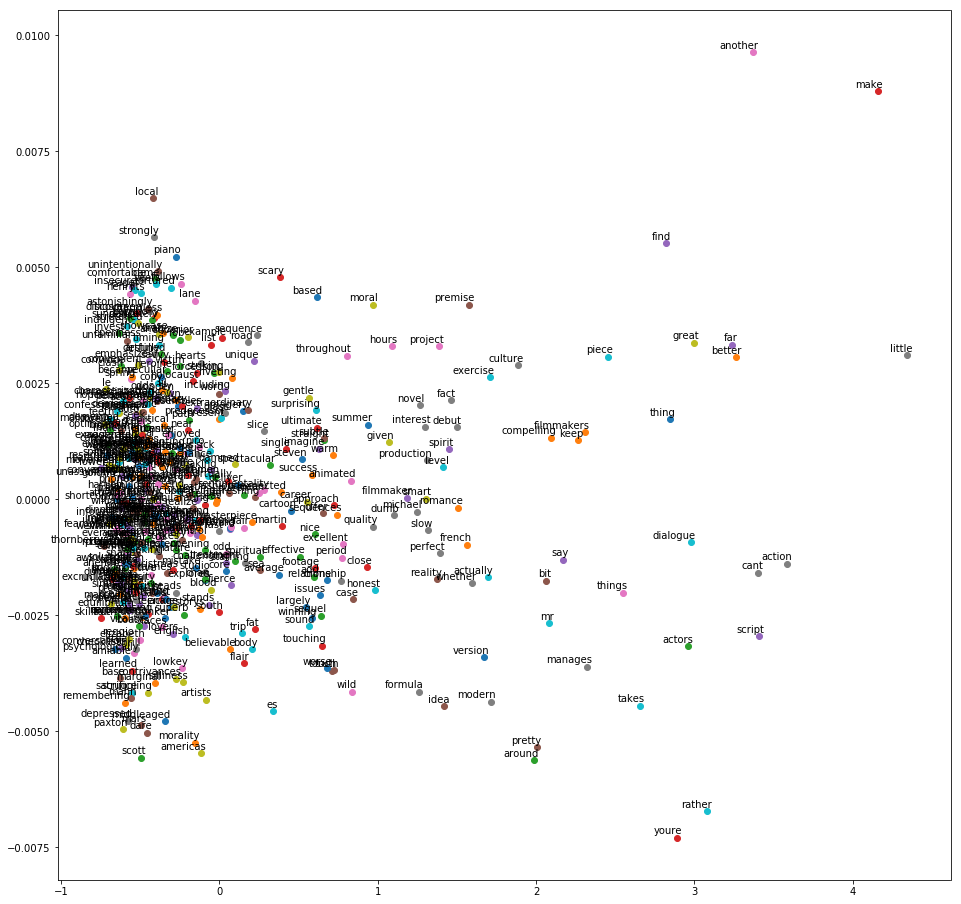

In [217]:
from sklearn.decomposition import PCA

def plot_with_labels(low_dim_embs, labels):
  plt.figure(figsize=(16, 16))
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

n_plot = 500
pca = PCA(n_components=2)
result = pca.fit_transform(final_embeddings[:n_plot, :])

labels = [words[i] for i in range(n_plot)]
plot_with_labels(result, labels)

In [ ]:
## embedding + CNN
from keras.layers.embeddings import Embedding

vocab_size = 100
max_length = 32

model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())



In [9]:
## An alternative way to train a word2vec with tensorflow

vocabulary_size = 1000
def build_dataset(words, n_words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])

print("shape of batch:", batch.shape, "shape of labels:", labels.shape)

Most common words (+UNK) [['UNK', 57362], ('the', 10194), ('a', 7336), ('and', 6264), ('of', 6148)]
Sample data [0, 301, 3, 673, 6, 36, 0, 3, 0, 62] ['UNK', 'silly', 'and', 'tedious', 'it', 'so', 'UNK', 'and', 'UNK', 'only']
301 silly -> 3 and
301 silly -> 0 UNK
3 and -> 673 tedious
3 and -> 301 silly
673 tedious -> 3 and
673 tedious -> 6 it
6 it -> 36 so
6 it -> 673 tedious
shape of batch: (8,) shape of labels: (8, 1)


In [20]:
batch_size = 64
embedding_size = 512  # Dimension of the embedding vector.
skip_window = 4  # How many words to consider left and right.
num_skips = 4  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample, used to adjust the weights.

valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()
with graph.as_default():

  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  with tf.device('/cpu:0'):
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(.1).minimize(loss)

  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                     valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  init = tf.global_variables_initializer()

In [22]:
# training.
num_steps = 80001
with tf.Session(graph=graph) as session:
  init.run()
  print('Initialized')

  average_loss = 0
  for step in range(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
    run_metadata = tf.RunMetadata()

    _, loss_val = session.run(
        [optimizer, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0
    
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  145.48324585
Nearest to from: elements, twists, slight, mr, enjoy, too, did, lost,
Nearest to good: guys, looks, absolutely, city, uses, often, mystery, turns,
Nearest to your: moments, period, dull, final, reveals, deeply, black, take,
Nearest to is: seen, tension, act, comes, create, murder, mostly, it,
Nearest to more: indulgent, style, occasionally, cinematic, thoughtful, head, ugly, still,
Nearest to an: charm, own, game, than, lack, certain, adults, did,
Nearest to UNK: amount, creative, cheap, flat, slightly, missing, convincing, sure,
Nearest to out: working, adventure, documentary, should, didn't, talent, day, think,
Nearest to their: ambitious, end, jokes, sit, needs, stylish, attempt, amount,
Nearest to characters: low, bit, having, standard, going, level, cinema, happy,
Nearest to something: children, high, remember, moving, age, ambitious, intimate, romance,
Nearest to makes: engaging, use, average, small, period, side, audiences, aga

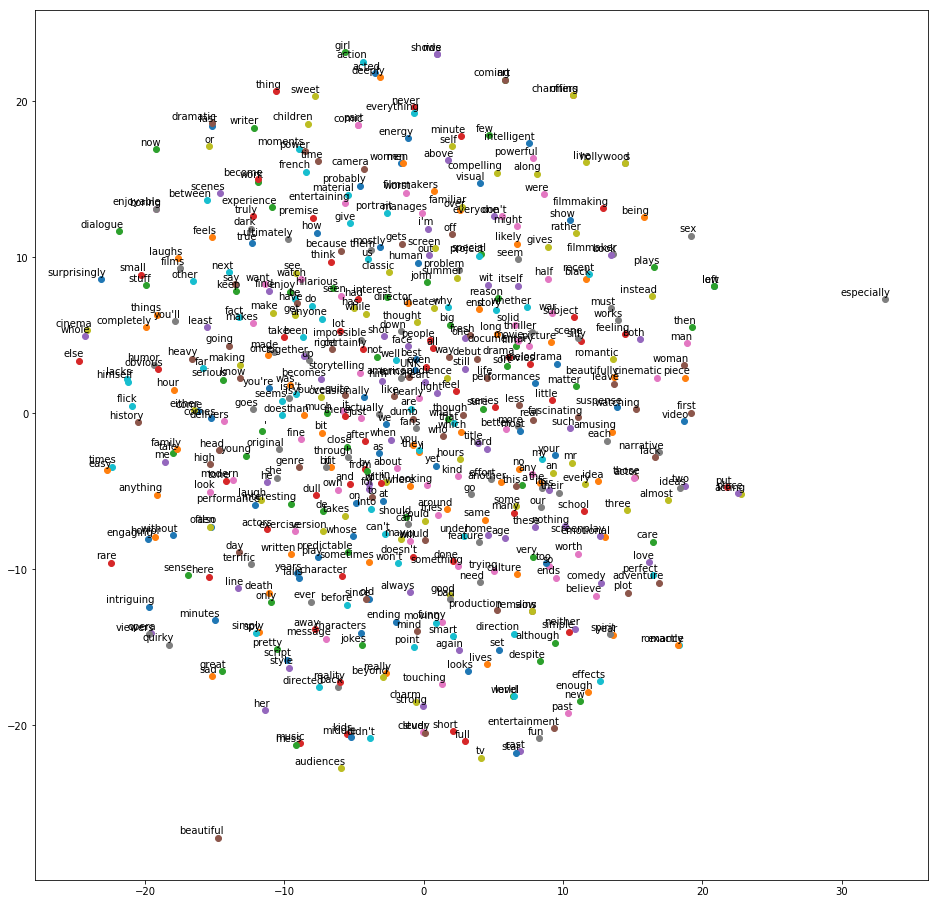

In [34]:
def plot_with_labels(low_dim_embs, labels):
  plt.figure(figsize=(16, 16))
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')


tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

In [28]:
def doc2vec():
    vec = []
    for doc in corpus:
        vec_sum = np.zeros([embedding_size])
        for word in doc:
            if word not in dictionary:
                word = "UNK"
            vec_sum += final_embeddings[dictionary[word]]
        vec.append(vec_sum)
    return np.array(vec)


In [30]:
X = doc2vec()
y = np.array([0]*5331 + [1]*5331)
print(X.shape, y.shape)

(10662, 512) (10662,)
